In [1]:
from learning_in_games import *

In [2]:
def get_update_indices(step, method, n_agents, uniform_size, fixed_independent_delays, initial_vector):
    if method == "uniform":
        random_vector = np.random.randint(0, high=uniform_size, size=n_agents)
        indices_to_update = np.where(random_vector == 0)
        return np.array(indices_to_update).flatten()
    elif method == "fixed":
        indices_to_update = np.where((step - initial_vector) % delay_parameter == 0)
        return np.array(indices_to_update).flatten()
    elif method == "fixed_independent":
        indices_to_update = np.where(((step - initial_vector) % fixed_independent_delays) == 0)
        return np.array(indices_to_update).flatten()

In [3]:
def imitate():
    for i in range(n_actions):
        other_actions = (np.ones(n_agents)*i).astype(int)
        other_rewards = np.ones(n_agents)*reward_per_action[i]
        Q, _ = bellman_update_q_table(Q, S, other_actions, other_rewards, S, agentConfig=imitationAgentConfig)
    return Q

In [4]:
n_iter = 30000

In [6]:
n_agents = 100
n_states = 1
n_actions = 3
cost = 0  # for Braess, the cost of the crossing link, typically 0

gameConfig = RouteConfig(n_agents, n_actions, n_states, cost)

alpha = np.random.uniform(low=0.01, high=1, size=n_agents)
alpha[0] = 1
alpha_imitation = 0.
gamma = 0.8
qinit = np.array([-2.01, -2.01, -2])
epsilon = "DECAYED" # np.random.uniform(low=0, high=0.1, size=n_agents)
imitation = False

agentConfig = EpsilonGreedyConfig(alpha, gamma, qinit, epsilon)
imitationAgentConfig = EpsilonGreedyConfig(alpha_imitation, gamma, qinit, epsilon)

delay_method = "fixed_independent"
delay_parameter = 1

fixed_independent_delays = np.random.randint(0, high=delay_parameter, size=n_agents)

if delay_method == "fixed":
    initial_vector = np.random.randint(0, high=100, size=n_agents)
else:
    initial_vector = np.random.randint(0, high=delay_parameter, size=n_agents)

name = f"S=1 if R.mean > 1-75 else S=0"

In [7]:
Q = initialize_q_table(qinit, n_agents, n_states, n_actions, qmin=-2, qmax=-1)
exp_start, exp_end, exp_decay = initialize_exploration_rates(n_iter, gameConfig, agentConfig)
exp_decay_factor = 8
M = {}
ind = np.arange(gameConfig.n_agents)
S = np.random.randint(gameConfig.n_states, size=gameConfig.n_agents)
# S[0] = 0
# S = Q[ind, S].argmax(axis=1)
# S = np.where(Q[ind, S].argmax(axis=1) == 2, 1, 0)

S_ = S

for t in range(n_iter):
    epsilon = update_exploration_rates(t, n_iter, exp_start=exp_start, exp_end=exp_end, exp_decay_factor=exp_decay_factor)
    
    A = e_greedy_select_action(Q, S, epsilon)

    R, _, reward_per_action = braess_augmented_network(A, n_agents, cost)
    # R = np.mean(R)

    indices_to_update = get_update_indices(t,
                                           delay_method,
                                           n_agents,
                                           uniform_size=delay_parameter,
                                           fixed_independent_delays=fixed_independent_delays,
                                           initial_vector=initial_vector)
    # print(indices_to_update)
    
    # S_ = np.where(Q[ind, S].argmax(axis=1) == 2, 1, 0)
    # S_ = np.ones(n_agents).astype(int) if R.mean() < -1.8 else np.zeros(n_agents).astype(int)
    # S_ = Q[ind, S].argmax(axis=1)
    # S_ = A 
    # S_  = np.where(A == 2, 1, 0)
    
    # S_[0] = 0
    
    Q, sum_of_belief_updates = bellman_update_q_table(indices_to_update, Q, S, A, R, S_, alpha, gamma)
    
    ## SAVE PROGRESS DATA
    M[t] = {
        "nA": np.bincount(A, minlength=gameConfig.n_actions),
        "R": R,
        "Q": Q[ind, S],
        "amax": Q[ind, S].argmax(axis=1),
        "costs": reward_per_action,
        "S": S,
    }
    
    S = S_

/var/folders/7t/2_7wyk_177jf958xdx0cky2r0000gn/T/ipykernel_22255/188269656.py:10: RuntimeWarning: divide by zero encountered in remainder
  indices_to_update = np.where(((step - initial_vector) % fixed_independent_delays) == 0)


In [8]:
x_vals = np.arange(0, n_iter, 1)
threshold = 0.5
W = np.array([-M[t]["R"].mean() for t in x_vals])[int(threshold*n_iter):-1]

In [10]:
def increase_decrease_run_length(W):
    differences = np.diff(W)
    increases = np.where(differences > 0, True, False)
    decreases = np.where(differences < 0, True, False)

    count_increase_len = np.diff(np.where(np.concatenate(([increases[0]],increases[:-1] != increases[1:],[True])))[0])[::2]
    count_decrease_len = np.diff(np.where(np.concatenate(([decreases[0]],decreases[:-1] != decreases[1:],[True])))[0])[::2]
    
    return count_increase_len.mean(), count_decrease_len.mean()

In [11]:
def increase_decrease_size(W):
    differences = np.diff(W)
    increase_indices = np.where(differences >= 0)
    decrease_indices = np.where(differences < 0)
    
    return differences[increase_indices].mean(), differences[decrease_indices].mean()

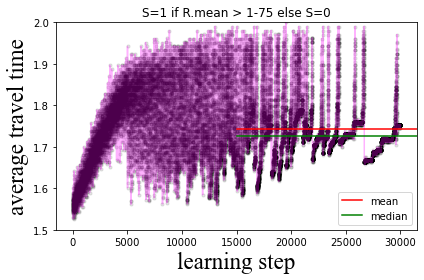

In [12]:
fig, ax = plt.subplots()
# ax.axhline(y=2.0, ls="--")
# ax.axhline(y=1.5, ls="--")
plt.plot(x_vals, [-M[t]["R"].mean() for t in x_vals], alpha=0.3, color="magenta")
plt.scatter(x_vals, [-M[t]["R"].mean() for t in x_vals], alpha=0.1, s=10, c="black")

mean = W.mean()
median = np.median(W)
ax.axhline(y=mean, xmin=threshold, xmax=1,label="mean", color="red")
ax.axhline(y=median, xmin=threshold, xmax=1, label="median", color="green")

plt.title(name)

plt.ylim(1.5, 2)
plt.xlabel("learning step", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.ylabel("average travel time", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.tight_layout()
plt.legend()
# plt.savefig(f"delay_experiments/braess_timeseries_state_average_threshold.png")

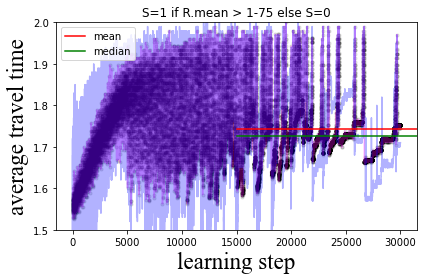

In [13]:
fig, ax = plt.subplots()
# ax.axhline(y=2.0, ls="--")
# ax.axhline(y=1.5, ls="--")
plt.plot(x_vals, [-M[t]["R"].mean() for t in x_vals], alpha=0.3, color="magenta")
plt.plot(x_vals, [-M[t]["R"][0] for t in x_vals], alpha=0.3, color="blue")
plt.scatter(x_vals, [-M[t]["R"].mean() for t in x_vals], alpha=0.1, s=10, c="black")

mean = W.mean()
median = np.median(W)
ax.axhline(y=mean, xmin=threshold, xmax=1,label="mean", color="red")
ax.axhline(y=median, xmin=threshold, xmax=1, label="median", color="green")

plt.title(name)

plt.ylim(1.5, 2)
plt.xlabel("learning step", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.ylabel("average travel time", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.tight_layout()
plt.legend()
# plt.savefig(f"delay_experiments/braess_timeseries_state_average_threshold.png")

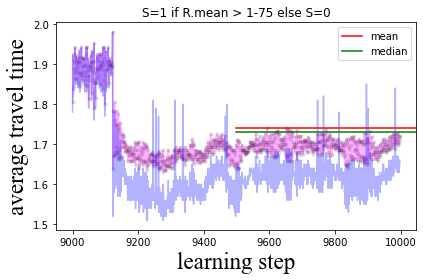

In [825]:
fig, ax = plt.subplots()
x_vals = np.arange(9000, 9999)
plt.plot(x_vals, [-M[t]["R"].mean() for t in x_vals], alpha=0.3, color="magenta")
plt.plot(x_vals, [-M[t]["R"][0] for t in x_vals], alpha=0.3, color="blue")
plt.scatter(x_vals, [-M[t]["R"].mean() for t in x_vals], alpha=0.1, s=10, c="black")

mean = W.mean()
median = np.median(W)
ax.axhline(y=mean, xmin=threshold, xmax=1,label="mean", color="red")
ax.axhline(y=median, xmin=threshold, xmax=1, label="median", color="green")

plt.title(name)

# plt.ylim(1.5, 2)
plt.xlabel("learning step", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.ylabel("average travel time", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.tight_layout()
plt.legend()
# plt.savefig(f"delay_experiments/braess_timeseries_state_average_threshold.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


-0.006669986998699866


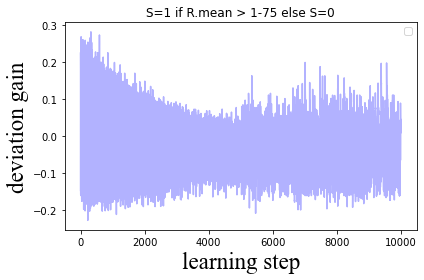

In [14]:
fig, ax = plt.subplots()
x_vals = np.arange(0, 9999)

welfare = np.array([-M[t]["R"].mean() for t in x_vals])
user0 = np.array([-M[t]["R"][0].mean() for t in x_vals])
deviation_gain = welfare - user0
print(deviation_gain.mean())

plt.plot(x_vals, deviation_gain, alpha=0.3, color="blue")

plt.title(name)

# plt.ylim(1.5, 2)
plt.xlabel("learning step", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.ylabel("deviation gain", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.tight_layout()
plt.legend()
# plt.savefig(f"delay_experiments/braess_timeseries_state_average_threshold.png")

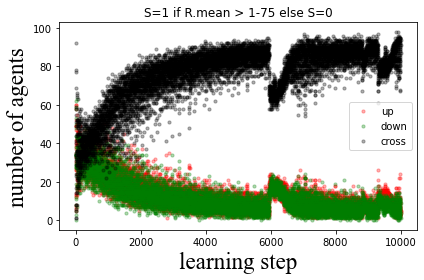

In [819]:
fig, ax = plt.subplots()
# ax.axhline(y=2.0, ls="--")
# ax.axhline(y=1.5, ls="--")
# plt.plot(x_vals, [-M[t]["R"].mean() for t in x_vals], alpha=0.3, color="magenta")
plt.scatter(x_vals, [M[t]["nA"][0] for t in x_vals], alpha=0.3, s=10, c="red", label="up")
plt.scatter(x_vals, [M[t]["nA"][1] for t in x_vals], alpha=0.3, s=10, c="green", label="down")
plt.scatter(x_vals, [M[t]["nA"][2] for t in x_vals], alpha=0.3, s=10, c="black", label="cross")

plt.title(name)

# plt.ylim(1.5, 2)
plt.xlabel("learning step", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.ylabel("number of agents", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.tight_layout()
plt.legend()
# plt.savefig(f"delay_experiments/action_fractions_{name}.png")

In [533]:
fraction_amax_c = [np.where(M[t]["amax"]==2, 1, 0).mean() for t in x_vals]

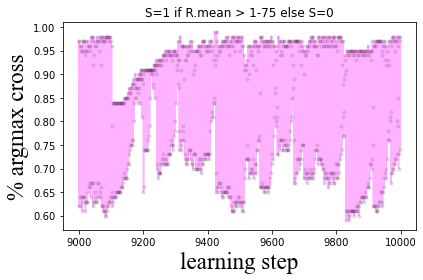

In [534]:
fig, ax = plt.subplots()
# ax.axhline(y=2.0, ls="--")
# ax.axhline(y=1.5, ls="--")
plt.plot(x_vals, fraction_amax_c, alpha=0.3, color="magenta")
plt.scatter(x_vals, fraction_amax_c, alpha=0.1, s=10, c="black")

plt.title(name)

# plt.ylim(1.5, 2)
plt.xlabel("learning step", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.ylabel("% argmax cross", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.tight_layout()
# plt.savefig(f"delay_experiments/braess_timeseries_{name}.png")

In [439]:
distance_cross = [(M[t]["Q"][ind, 2] - M[t]["costs"][2]).mean() for t in x_vals]
distance_up = [(M[t]["Q"][ind, 0] - M[t]["costs"][0]).mean() for t in x_vals]
distance_down = [(M[t]["Q"][ind, 1] - M[t]["costs"][1]).mean() for t in x_vals]

total_distance = np.abs(distance_cross) + np.abs(distance_up) + np.abs(distance_down)

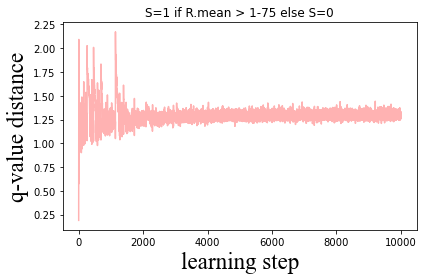

In [440]:
fig, ax = plt.subplots()
# ax.axhline(y=2.0, ls="--")
# ax.axhline(y=1.5, ls="--")
# plt.plot(x_vals, distance_cross, alpha=0.3, color="magenta")
# plt.plot(x_vals, distance_up, alpha=0.3, color="blue")
# plt.plot(x_vals, distance_down, alpha=0.3, color="red")
plt.plot(x_vals, total_distance, alpha=0.3, color="red")
# plt.scatter(x_vals, distance_mean, alpha=0.1, s=10, c="black")

plt.title(name)

# plt.ylim(1.5, 2)
plt.xlabel("learning step", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.ylabel("q-value distance", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.tight_layout()
# plt.savefig(f"delay_experiments/braess_timeseries_{name}.png")

In [441]:
distance_up_cross = [(M[t]["Q"][ind, 2] - M[t]["Q"][ind, 0]).mean() for t in x_vals]
distance_down_cross = [(M[t]["Q"][ind, 2] - M[t]["Q"][ind, 1]).mean() for t in x_vals]
distance_mean = (np.array(distance_up_cross) + np.array(distance_down_cross))/2

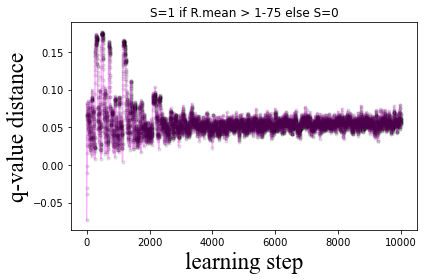

In [442]:
fig, ax = plt.subplots()
# ax.axhline(y=2.0, ls="--")
# ax.axhline(y=1.5, ls="--")
plt.plot(x_vals, distance_mean, alpha=0.3, color="magenta")
plt.scatter(x_vals, distance_mean, alpha=0.1, s=10, c="black")

plt.title(name)

# plt.ylim(1.5, 2)
plt.xlabel("learning step", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.ylabel("q-value distance", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.tight_layout()
# plt.savefig(f"delay_experiments/braess_timeseries_{name}.png")

In [443]:
distance_dominance_ratio = distance_mean/fraction_amax_c

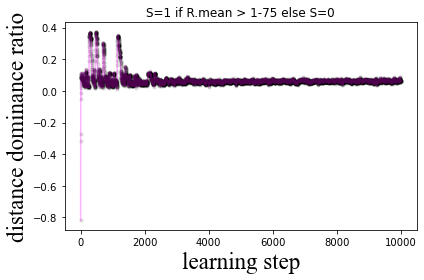

In [444]:
fig, ax = plt.subplots()
# ax.axhline(y=2.0, ls="--")
# ax.axhline(y=1.5, ls="--")
plt.plot(x_vals, distance_dominance_ratio, alpha=0.3, color="magenta")
plt.scatter(x_vals, distance_dominance_ratio, alpha=0.1, s=10, c="black")

plt.title(name)

# plt.ylim(1.5, 2)
plt.xlabel("learning step", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.ylabel("distance dominance ratio", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.tight_layout()
# plt.savefig(f"delay_experiments/braess_timeseries_{name}.png")

## Detecting Cycles Sweep

In [15]:
def run(param, initial_alpha):
    n_iter = 10000
    n_agents = 100
    n_states = 1
    n_actions = 3
    cost = 0  # for Braess, the cost of the crossing link, typically 0

    gameConfig = RouteConfig(n_agents, n_actions, n_states, cost)

    alpha = initial_alpha
    alpha[0] = param
    alpha_imitation = 0.
    gamma = 0
    qinit = np.array([-2.01, -2.01, -2]) # "UNIFORM"
    epsilon = "DECAYED"
    imitation = False

    agentConfig = EpsilonGreedyConfig(alpha, gamma, qinit, epsilon)
    imitationAgentConfig = EpsilonGreedyConfig(alpha_imitation, gamma, qinit, epsilon)

    delay_method = "fixed_independent"
    delay_parameter = 1

    fixed_independent_delays = np.random.randint(0, high=delay_parameter, size=n_agents)

    if delay_method == "fixed":
        initial_vector = np.random.randint(0, high=100, size=n_agents)
    else:
        initial_vector = np.random.randint(0, high=delay_parameter, size=n_agents)

    name = f"method({delay_method})_parameter({delay_parameter})"

    Q = initialize_q_table(qinit, n_agents, n_states, n_actions, qmin=-2, qmax=-1)
    exp_start, exp_end, exp_decay = initialize_exploration_rates(n_iter, gameConfig, agentConfig)
    exp_decay_factor = 8
    M = {}
    ind = np.arange(gameConfig.n_agents)
    S = np.random.randint(gameConfig.n_states, size=gameConfig.n_agents)
    # S[0] = 0
    # S = Q[ind, S].argmax(axis=1)
    # S = np.where(Q[ind, S].argmax(axis=1) == 2, 1, 0)

    S_ = S

    for t in range(n_iter):
        epsilon = update_exploration_rates(t, n_iter, exp_start=exp_start, exp_end=exp_end, exp_decay_factor=exp_decay_factor)

        A = e_greedy_select_action(Q, S, epsilon)

        R, _, reward_per_action = braess_augmented_network(A, n_agents, cost)
        # R = np.mean(R)

        indices_to_update = get_update_indices(t,
                                               delay_method,
                                               n_agents,
                                               uniform_size=delay_parameter,
                                               fixed_independent_delays=fixed_independent_delays,
                                               initial_vector=initial_vector)
        # print(indices_to_update)

        # S_ = np.where(Q[ind, S].argmax(axis=1) == 2, 1, 0)
        # S_ = np.ones(n_agents).astype(int) if R.mean() < -param else np.zeros(n_agents).astype(int)
        # S_ = Q[ind, S].argmax(axis=1)
        # S_ = A 
        # S_  = np.where(A == 2, 1, 0)
        # S_ = np.ones(n_agents).astype(int) if np.where(A == 2)[0].shape[0] >= param else np.zeros(n_agents).astype(int)
        # S_ = np.where(Q[ind, S].argmax(axis=1) == 2, np.logical_not(S), S)
        # S_[0] = 0

        Q, sum_of_belief_updates = bellman_update_q_table(indices_to_update, Q, S, A, R, S_, alpha, gamma)

        ## SAVE PROGRESS DATA
        M[t] = {
            "nA": np.bincount(A, minlength=gameConfig.n_actions),
            "R": R,
            "Q": Q[ind, S],
            "amax": Q[ind, S].argmax(axis=1),
            "costs": reward_per_action,
            "S": S,
        }

        S = S_
    return M

In [45]:
parameters = np.linspace(0, 1, 101)
initial_alpha = np.random.uniform(low=0.3, high=0.7, size=n_agents)
x_vals = np.arange(0, 10000)
ind = np.arange(100)

In [46]:
results = {}
for param in parameters:
    M = run(param, initial_alpha)
    W = np.array([-M[t]["R"].mean() for t in x_vals])
    user0 = np.array([-M[t]["R"][0].mean() for t in x_vals])
    deviation_gain = W - user0
    W_smooth = np.convolve(W, np.ones(100)/100, mode="valid")
    
    len_up, len_down = increase_decrease_run_length(W_smooth)
    mean_up, mean_down = increase_decrease_size(W)
    
    results[param] = {
        "W": W,
        "user0": user0,
        "deviation_gain": deviation_gain,
        "mean": W[int(0.8*x_vals[-1]):-1].mean(),
        "variance": W[int(0.8*x_vals[-1]):-1].var(),
        "len_up": len_up,
        "len_down": len_down,
        "mean_up": mean_up,
        "mean_down": mean_down
    }

/var/folders/7t/2_7wyk_177jf958xdx0cky2r0000gn/T/ipykernel_22255/188269656.py:10: RuntimeWarning: divide by zero encountered in remainder
  indices_to_update = np.where(((step - initial_vector) % fixed_independent_delays) == 0)


In [47]:
experiment_name = "alpha_all05_variance_epsilon_decayed"

In [48]:
mean = np.array([results[p]["mean"] for p in parameters])
variance = np.array([results[p]["variance"] for p in parameters])
length_differences = np.array([results[p]["len_up"]-results[p]["len_down"] for p in parameters])
mean_differences = np.array([results[p]["mean_up"]-results[p]["mean_down"] for p in parameters])

In [49]:
user0_gain = np.array([results[p]["deviation_gain"].mean() for p in parameters])

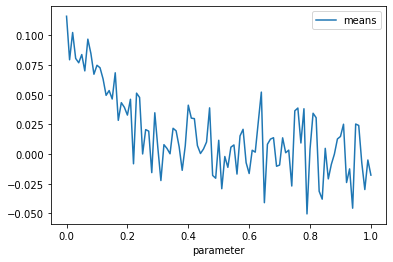

In [50]:
# plt.plot(parameters, length_differences, label="run length")
plt.plot(parameters, user0_gain, label="means")
# plt.ylim(0)
plt.legend()
plt.xlabel("parameter")
plt.savefig(f"delay_experiments/sweep_{experiment_name}_user0_gain.pdf")

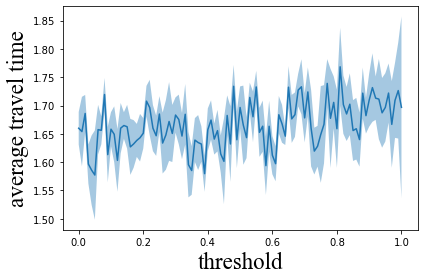

In [50]:
plt.plot(parameters, mean, label="means")
plt.fill_between(parameters, mean+np.sqrt(variance), mean-np.sqrt(variance), alpha=0.4)
plt.xlabel("threshold", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.ylabel("average travel time", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.tight_layout()
plt.savefig(f"delay_experiments/sweep_{experiment_name}_traveltime.pdf")

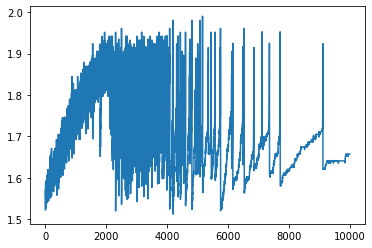

In [52]:
plt.plot(results[0]["W"])

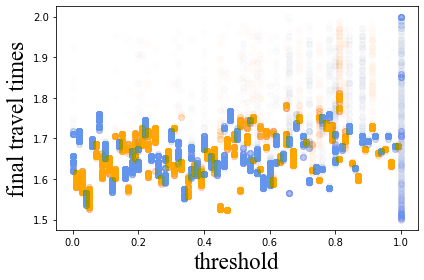

In [51]:
switch = True
for p in parameters:
    
    if switch:
        color = "cornflowerblue"
        switch = False
    else:
        color = "orange"
        switch = True
    
    points = results[p]["W"][-1000:-1]
    h_vals = np.ones(len(points)) * p
    
    plt.scatter(h_vals, points, alpha=0.01, color=color)
    
plt.xlabel("threshold", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.ylabel("final travel times", fontdict={"font": "Times New Roman", "fontsize": 23})
plt.tight_layout()
plt.savefig(f"delay_experiments/sweep_{experiment_name}_traveltime_scatter.pdf")